In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/Minor_Project

archive.zip	       final.zip	Nov_3.ipynb	    Untitled0.ipynb
augmented_dataset.zip  new_dataset.zip	ResNet_50_C5.ipynb  Xception_1.ipynb


In [3]:
!unzip -qq 'drive/MyDrive/Minor_Project/archive.zip' -d 'dataset/'

In [15]:
!ls dataset/dataset2

auto_test  test  train	val


In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2
from skimage import exposure

In [17]:
np.random.seed(12049)

In [18]:
def get_classes(data_path, classes, data):
    print(f"----{data}----")
    knee_severity={}
    count=0

    for i in range(len(classes)):
        imgs=os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i]=imgs
        count+=len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k}-{classes[k]}: {len(v)} images, {round((len(v)*100)/count, 2)}%"
        )

    return knee_severity

def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data}-{classes[k]}")
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path=os.path.join(data_path, str(k), v[i])
            img=tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1+i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

In [19]:
class_names=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [20]:
base_dir="dataset/dataset2/"
train_path=os.path.join(base_dir, 'train')
valid_path=os.path.join(base_dir, 'val')
test_path=os.path.join(base_dir, 'test')

In [21]:
train_data=get_classes(train_path, class_names, 'Train')
valid_data=get_classes(valid_path, class_names, 'Valid')
test_data=get_classes(test_path, class_names, 'Test')

----Train----
Grade 0-Healthy: 2286 images, 39.56%
Grade 1-Doubtful: 1046 images, 18.1%
Grade 2-Minimal: 1516 images, 26.24%
Grade 3-Moderate: 757 images, 13.1%
Grade 4-Severe: 173 images, 2.99%
----Valid----
Grade 0-Healthy: 328 images, 39.71%
Grade 1-Doubtful: 153 images, 18.52%
Grade 2-Minimal: 212 images, 25.67%
Grade 3-Moderate: 106 images, 12.83%
Grade 4-Severe: 27 images, 3.27%
----Test----
Grade 0-Healthy: 639 images, 38.59%
Grade 1-Doubtful: 296 images, 17.87%
Grade 2-Minimal: 447 images, 26.99%
Grade 3-Moderate: 223 images, 13.47%
Grade 4-Severe: 51 images, 3.08%


Train data-Healthy


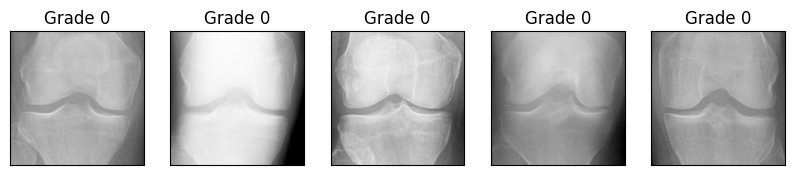

Train data-Doubtful


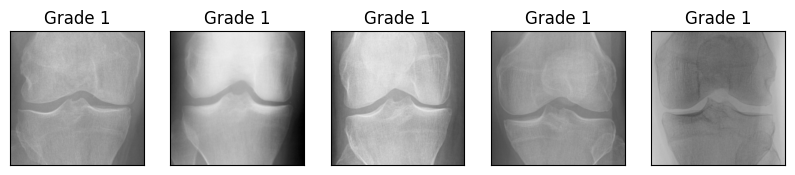

Train data-Minimal


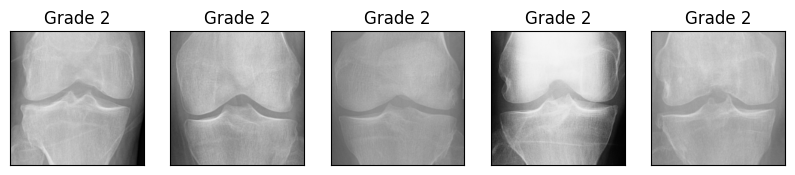

Train data-Moderate


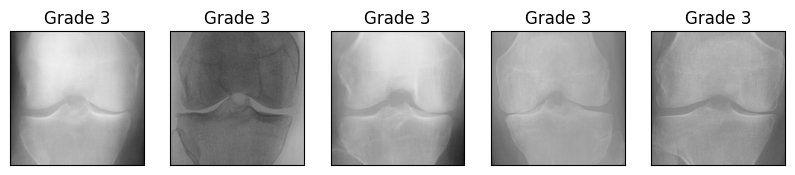

Train data-Severe


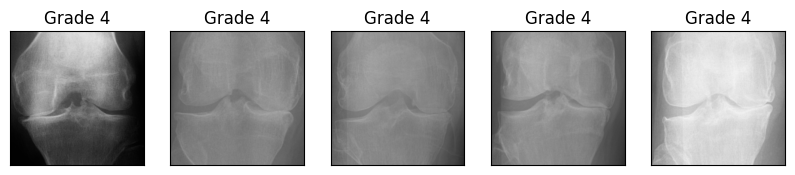

In [22]:
plot_classes(train_data, train_path, class_names, 'Train data')

In [23]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [24]:
model_name="EfficientNet-V2B3"

target_size=(224, 224)
epochs=40
batch_size=256
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.hdf5')

In [25]:
def custom_preprocessing(img):
    # Convert the image to grayscale (if it's not already)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.dtype != np.uint8:
        img = np.uint8(img)

    # Apply histogram equalization
    equalized_img = cv2.equalizeHist(img)

    # If needed, convert the equalized image back to 3 channels (RGB)
    equalized_img = cv2.cvtColor(equalized_img, cv2.COLOR_GRAY2BGR)

    return equalized_img

Found 5778 images belonging to 5 classes.


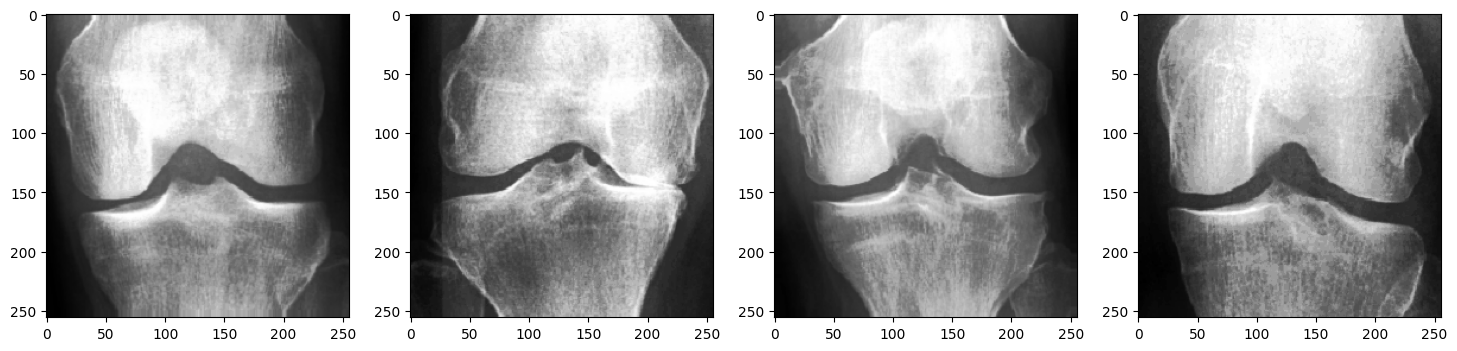

In [26]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    brightness_range=[0.4, 0.6],
    zoom_range=0.05,
    fill_mode="nearest",
)
imagegen=datagen.flow_from_directory(train_path, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype("uint8"))
plt.show()

In [27]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    brightness_range=[0.4, 0.6],
    zoom_range=0.05,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
)

In [29]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [30]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [33]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}
{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [34]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

52606240/52606240 [==============================] - 0s 0us/step


In [35]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 12938307 (49.36 MB)
Trainable params: 12829091 (48.94 MB)
Non-trainable params: 109216 (426.62 KB)
_________________________________________________________________


In [36]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/40
181/181 [==============================] - 210s 656ms/step - loss: 1.1277 - accuracy: 0.4337 - val_loss: 0.9939 - val_accuracy: 0.5932
Epoch 2/40
181/181 [==============================] - 109s 599ms/step - loss: 0.9165 - accuracy: 0.5440 - val_loss: 0.9453 - val_accuracy: 0.5714
Epoch 3/40
181/181 [==============================] - 108s 595ms/step - loss: 0.8017 - accuracy: 0.5877 - val_loss: 0.9034 - val_accuracy: 0.6065
Epoch 4/40
181/181 [==============================] - 109s 603ms/step - loss: 0.7370 - accuracy: 0.6255 - val_loss: 0.8744 - val_accuracy: 0.6186
Epoch 5/40
181/181 [==============================] - 108s 598ms/step - loss: 0.7055 - accuracy: 0.6404 - val_loss: 0.9482 - val_accuracy: 0.6053
Epoch 6/40
181/181 [==============================] - 110s 610ms/step - loss: 0.6739 - accuracy: 0.6452 - val_loss: 0.8916 - val_accuracy: 0.6295
Epoch 7/40
181/181 [==============================] - 108s 597ms/step - loss: 0.6566 - accuracy: 0.6658 - val_loss: 0.9410 -

In [37]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model EfficientNet-V2B3 fine tuning executed in 86.77 minutes


In [38]:
model_ft.save(save_model_ft)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


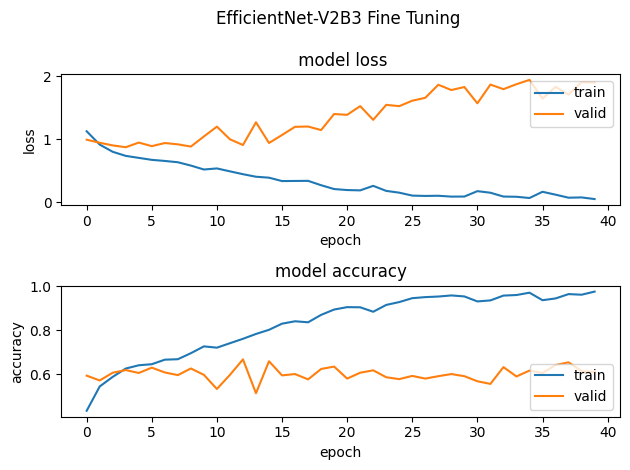

In [39]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [40]:
get_evaluate(valid_generator, "Valid", model_ft)

26/26 [==============================] - 3s 103ms/step - loss: 1.9015 - accuracy: 0.6102
Valid loss:  1.90
Valid accuracy:  0.61


In [41]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

26/26 [==============================] - 5s 86ms/step
Accuracy Score - EfficientNet-V2B3:  0.61
Balanced Accuracy Score - EfficientNet-V2B3:  0.66


              precision    recall  f1-score   support

           0       0.72      0.68      0.70       328
           1       0.28      0.37      0.32       153
           2       0.63      0.57      0.60       212
           3       0.80      0.74      0.77       106
           4       0.83      0.93      0.88        27

    accuracy                           0.61       826
   macro avg       0.66      0.66      0.65       826
weighted avg       0.63      0.61      0.62       826



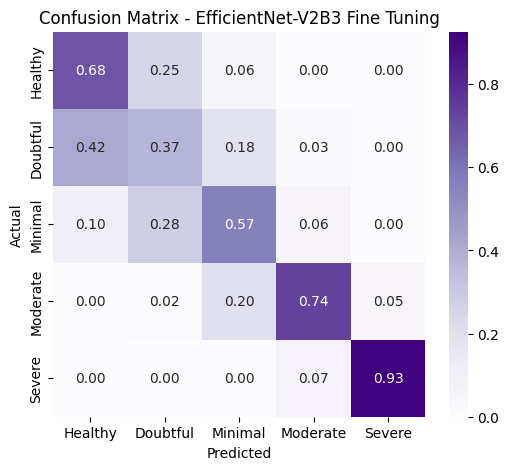

In [42]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [43]:
test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1656 images belonging to 5 classes.


In [44]:
y_test = test_generator.labels

In [45]:
EfficientNet = tf.keras.models.load_model('models/model_EfficientNet-V2B3_ft.hdf5')

In [46]:
predictions_EfficientNet = EfficientNet.predict(test_generator)
score_EfficientNet=EfficientNet.evaluate(test_generator, verbose=1)
print('Test loss:', score_EfficientNet[0])
print('Test acc:', score_EfficientNet[1])

7/7 [==============================] - 9s 676ms/step - loss: 1.6671 - accuracy: 0.6310
Test loss: 1.667093276977539
Test acc: 0.6310386657714844


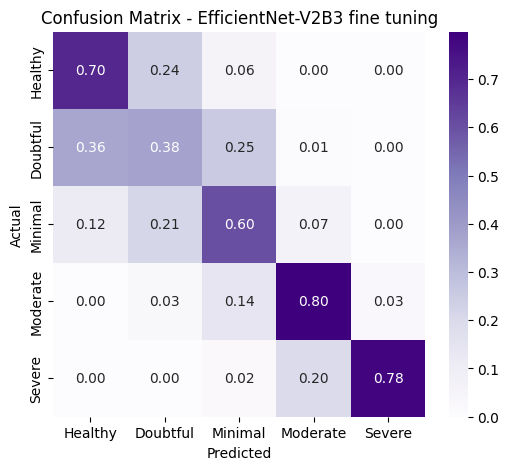

In [47]:
compute_confusion_matrix(
    test_generator,
    predictions_EfficientNet,
    class_names,
    f"{model_name} fine tuning",
)

In [48]:
EfficientNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 12938307 (49.36 MB)
Trainable params: 12829091 (48.94 MB)
Non-trainable params: 109216 (426.62 KB)
_________________________________________________________________


In [49]:
def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        superimposed_img
    )

    return superimposed_img

In [50]:
tests_data = get_classes(test_path, class_names, 'test')

----test----
Grade 0-Healthy: 639 images, 38.59%
Grade 1-Doubtful: 296 images, 17.87%
Grade 2-Minimal: 447 images, 26.99%
Grade 3-Moderate: 223 images, 13.47%
Grade 4-Severe: 51 images, 3.08%


In [51]:
# Last layer
conv_output = EfficientNet.get_layer("global_average_pooling2d").input

grad_model = tf.keras.models.Model(
    [EfficientNet.inputs], [conv_output, EfficientNet.output]
)

# model
EfficientNet.layers[-1].activation = None

Test data - Healthy


<ipython-input-49-2d181d1b2dd0>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


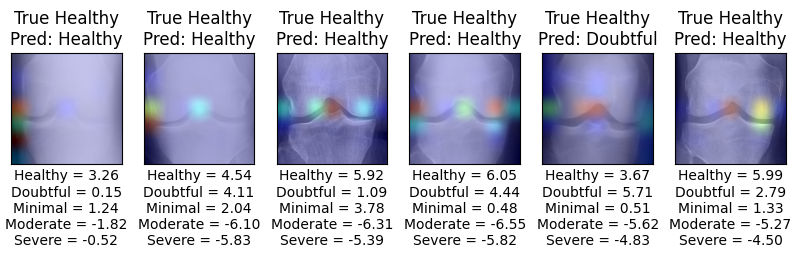

Test data - Doubtful


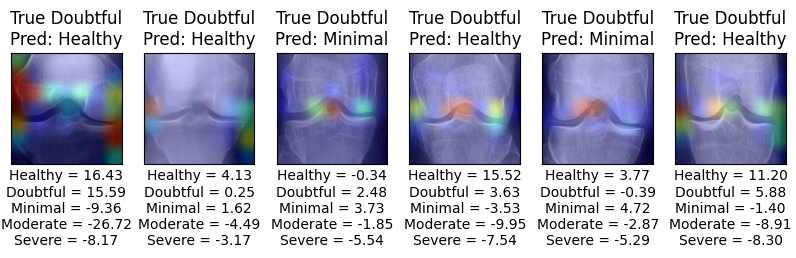

Test data - Minimal


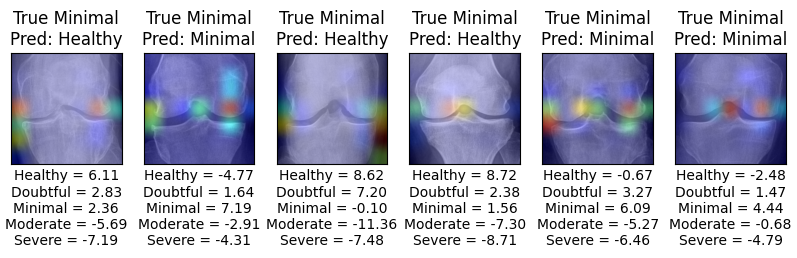

Test data - Moderate


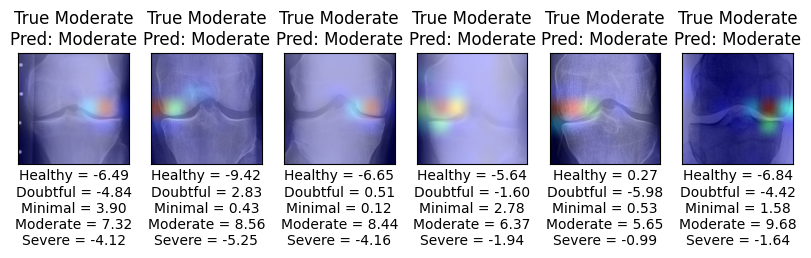

Test data - Severe


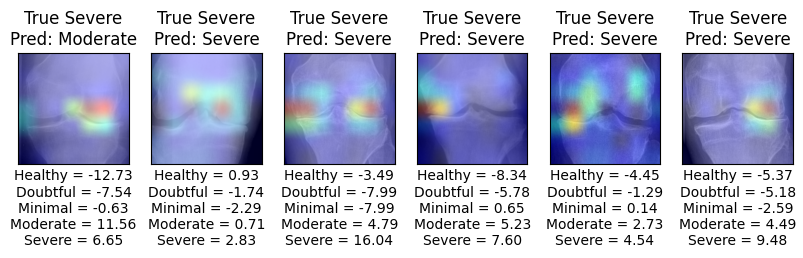

In [52]:
for k, v in tests_data.items():
    print(f"Test data - {class_names[k]}")
    plt.figure(figsize=(10, 28))
    for i in range(6):
        img_path = os.path.join(test_path, str(k), v[i])
        # prepare image
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        img = tf.keras.preprocessing.image.img_to_array(img)

        img_aux = img.copy()
        img_array = np.expand_dims(img_aux, axis=0)
        img_array = np.float32(img_array)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

        y_pred = EfficientNet.predict(img_array, verbose=0)[0]

        heatmap = make_gradcam_heatmap(grad_model, img_array)
        image = save_and_display_gradcam(img, heatmap)

        plt.subplot(1, 6, 1 + i, xticks=[], yticks=[])
        plt.imshow(image)
        plt.title(
            f"True {class_names[k]}\nPred: {class_names[np.argmax(y_pred)]}"
        )
        plt.xlabel(
            "\n".join([f"{c} = {p:.2f}" for c, p in zip(class_names, y_pred)])
        )
    plt.show()

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix_a(ytrue, ypred, class_names, model_name):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    # Create a custom color map ranging from yellow to red
    cmap = sns.color_palette("YlOrRd", as_cmap=True)

    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm,  # Use the actual confusion matrix
        annot=True,
        fmt="d",  # Use "d" to display actual counts
        cmap=cmap,  # Use the custom color map
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

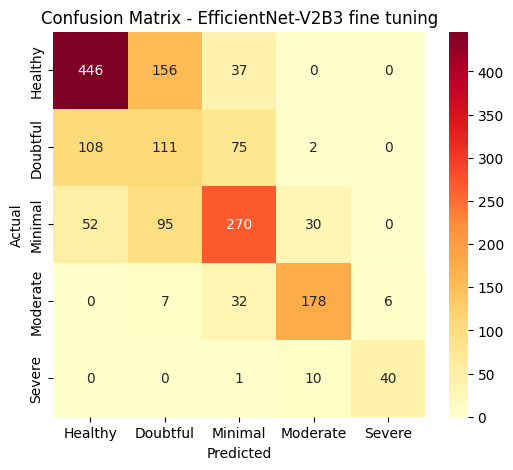

In [54]:
compute_confusion_matrix_a(
    test_generator,
    predictions_EfficientNet,
    class_names,
    f"{model_name} fine tuning",
)